Initializing population...

--- Generation 1/100 ---
Calculating fitnesses...
Speciating population...
Number of species: 3
Avg Raw Score: 2.224, Best Raw Score: 2.545
Avg Adjusted (Shared) Fitness: 0.138
Creating next generation...
Population diversity (avg pairwise genomic distance): 1.788

--- Generation 2/100 ---
Calculating fitnesses...
Speciating population...
Number of species: 3
Avg Raw Score: 2.186, Best Raw Score: 2.673
Avg Adjusted (Shared) Fitness: 0.128
Creating next generation...
Population diversity (avg pairwise genomic distance): 1.717

--- Generation 3/100 ---
Calculating fitnesses...
Speciating population...
Number of species: 3
Avg Raw Score: 2.229, Best Raw Score: 2.763
Avg Adjusted (Shared) Fitness: 0.135
Creating next generation...
Population diversity (avg pairwise genomic distance): 1.665

--- Generation 4/100 ---
Calculating fitnesses...
Speciating population...
Number of species: 3
Avg Raw Score: 2.122, Best Raw Score: 2.677
Avg Adjusted (Shared) Fitness: 0.1

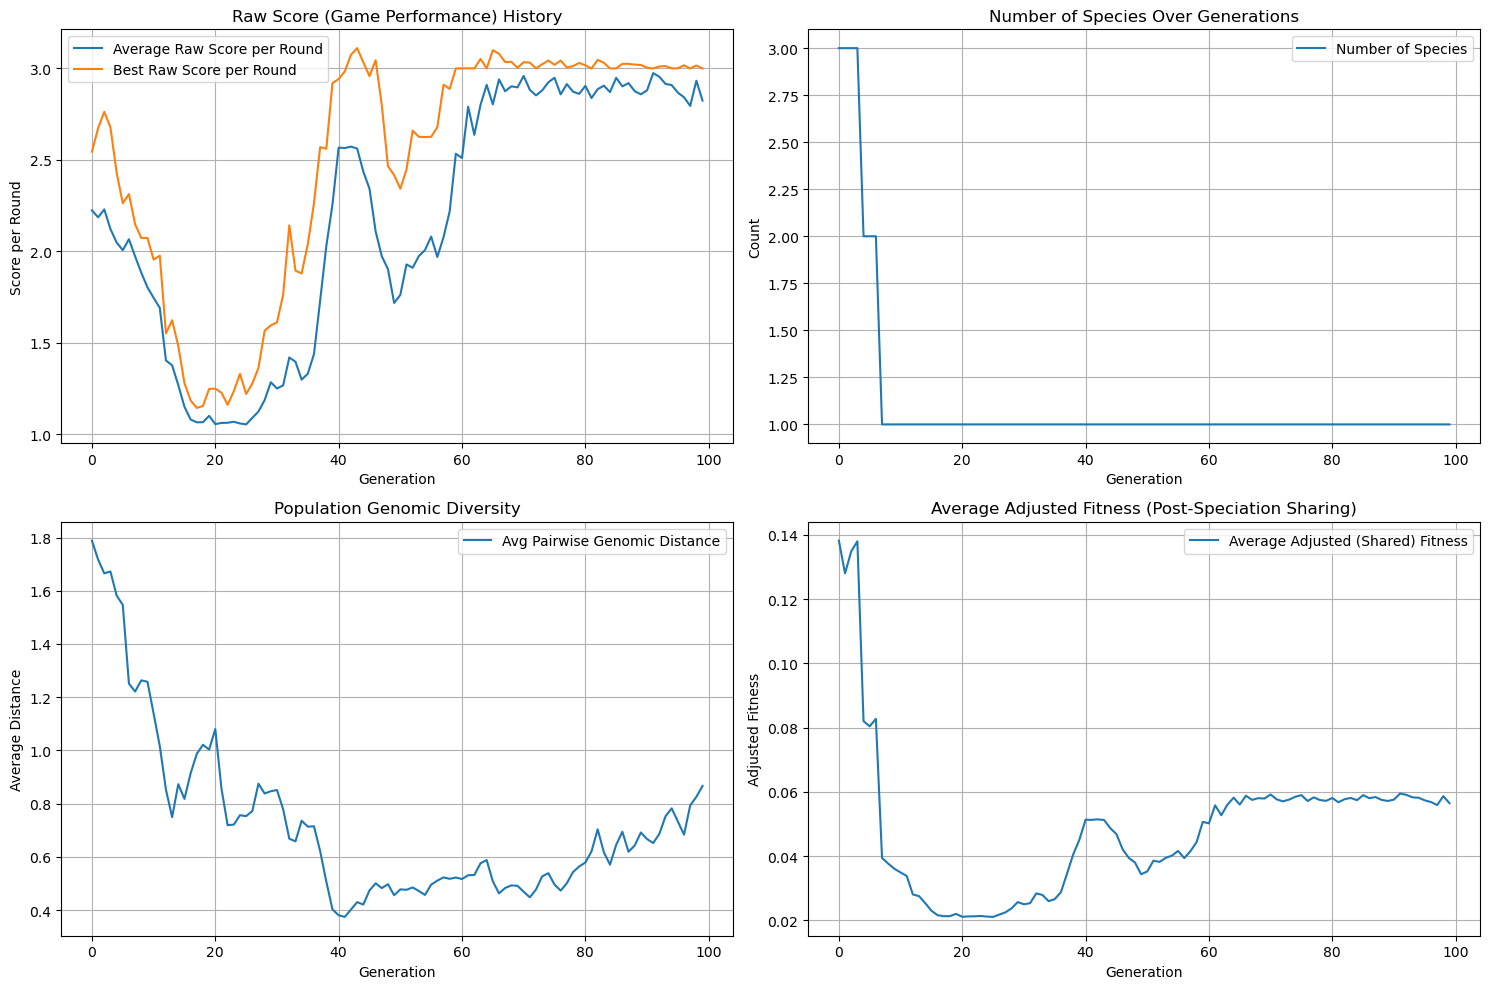


--- Analysis of Final Population ---

Best 5 individuals (by raw score):
Individual 5000: Raw Score: 3.000, Species: 4950
  Strategy Highlights (P(Cooperate)):
    P(C | My C,C; Opp C,C): 1.00 (Idx 0)
    P(C | My C,C; Opp D,D): 0.79 (Idx 3)
    P(C | My D,D; Opp C,C): 0.91 (Idx 12)
    P(C | My D,D; Opp D,D): 0.42 (Idx 15)
Individual 5001: Raw Score: 3.000, Species: 4950
  Strategy Highlights (P(Cooperate)):
    P(C | My C,C; Opp C,C): 1.00 (Idx 0)
    P(C | My C,C; Opp D,D): 0.57 (Idx 3)
    P(C | My D,D; Opp C,C): 0.95 (Idx 12)
    P(C | My D,D; Opp D,D): 0.47 (Idx 15)
Individual 5002: Raw Score: 0.000, Species: None
  Strategy Highlights (P(Cooperate)):
    P(C | My C,C; Opp C,C): 1.00 (Idx 0)
    P(C | My C,C; Opp D,D): 0.62 (Idx 3)
    P(C | My D,D; Opp C,C): 0.94 (Idx 12)
    P(C | My D,D; Opp D,D): 0.53 (Idx 15)
Individual 5003: Raw Score: 0.000, Species: None
  Strategy Highlights (P(Cooperate)):
    P(C | My C,C; Opp C,C): 1.00 (Idx 0)
    P(C | My C,C; Opp D,D): 0.74 (Idx 3

In [11]:
# In a Jupyter Notebook cell

# %load_ext autoreload
# %autoreload 2 
# (Uncomment above if you make changes to rpd_utils.py and want to reload automatically)

import matplotlib.pyplot as plt
import numpy as np
import random
from copy import deepcopy

import rpd_utils as rpd # Assuming rpd_utils.py is in the same directory

# --- Configuration Parameters ---
POPULATION_SIZE = 50
N_GENERATIONS = 100
GENOME_LENGTH = rpd.GENOME_LENGTH # Should be 16

# Game parameters
ROUNDS_PER_GAME = 100  # Number of rounds in a single RPD game
N_OPPONENTS_TO_PLAY = 10 # Each individual plays against N other individuals for fitness evaluation

# GA parameters
TOURNAMENT_K = 5       # Size of tournament for selection
ELITE_SIZE = 2          # Number of best individuals to carry to next generation
MUTATION_RATE = 0.1    # Probability of mutating a single gene
MUTATION_STRENGTH = 0.1 # Std deviation for Gaussian mutation
CROSSOVER_RATE = 0.8   # Probability of performing crossover

# Choose crossover function:
# CROSSOVER_FUNCTION = rpd.uniform_crossover
# CROSSOVER_ARGS = {} # No extra args for uniform

CROSSOVER_FUNCTION = rpd.blx_alpha_crossover
CROSSOVER_ARGS = {'crossover_alpha': 0.5}


# Speciation parameters
COMPATIBILITY_THRESHOLD = 2.0 # Genomic distance threshold for speciation (tune this)
ENABLE_SPECIATION = True

# --- Data Collection ---
avg_fitness_history = []
best_fitness_history = [] # Based on raw avg_score_per_round
avg_raw_score_history = []
num_species_history = []
population_diversity_history = [] # Avg pairwise genomic distance

# --- Helper for Diversity ---
def calculate_population_diversity(population):
    if len(population) < 2:
        return 0.0
    distances = []
    for i in range(len(population)):
        for j in range(i + 1, len(population)):
            dist = rpd.genomic_distance(population[i], population[j])
            distances.append(dist)
    return np.mean(distances) if distances else 0.0


# --- Main GA Loop ---
print("Initializing population...")
population = rpd.initialize_population(POPULATION_SIZE)
next_individual_id = POPULATION_SIZE # To keep track of unique IDs

for generation in range(N_GENERATIONS):
    print(f"\n--- Generation {generation + 1}/{N_GENERATIONS} ---")

    # 1. Calculate raw fitness (average score per round)
    print("Calculating fitnesses...")
    rpd.calculate_fitnesses(population, N_OPPONENTS_TO_PLAY, ROUNDS_PER_GAME)

    # Store raw scores before potential modification by speciation
    current_raw_scores = [ind.avg_score_per_round for ind in population]
    avg_raw_score = np.mean(current_raw_scores) if current_raw_scores else 0
    best_raw_score = np.max(current_raw_scores) if current_raw_scores else 0
    avg_raw_score_history.append(avg_raw_score)
    best_fitness_history.append(best_raw_score) # Tracking best based on actual game performance

    # 2. Speciation and Fitness Sharing (updates ind.fitness)
    num_species = 1
    if ENABLE_SPECIATION and len(population) > 0 :
        print("Speciating population...")
        species_reps, species_members_map = rpd.speciate_population(population, COMPATIBILITY_THRESHOLD)
        num_species = len(species_reps)
        print(f"Number of species: {num_species}")
        # Fitness is now adjusted (shared) within rpd.speciate_population
    else: # If speciation disabled, fitness is simply the avg_score_per_round
        for ind in population:
            ind.fitness = ind.avg_score_per_round # Ensure fitness is set if speciation is off
    
    num_species_history.append(num_species)

    # Log average adjusted fitness (after sharing)
    current_adj_fitnesses = [ind.fitness for ind in population]
    avg_adj_fitness = np.mean(current_adj_fitnesses) if current_adj_fitnesses else 0
    avg_fitness_history.append(avg_adj_fitness)
    
    print(f"Avg Raw Score: {avg_raw_score:.3f}, Best Raw Score: {best_raw_score:.3f}")
    if ENABLE_SPECIATION:
        print(f"Avg Adjusted (Shared) Fitness: {avg_adj_fitness:.3f}")

    # 3. Create next generation
    print("Creating next generation...")
    population, next_individual_id = rpd.create_next_generation(
        population,
        elite_size=ELITE_SIZE,
        tournament_k=TOURNAMENT_K,
        crossover_fn=CROSSOVER_FUNCTION,
        crossover_rate=CROSSOVER_RATE,
        mutation_fn=rpd.gaussian_mutation,
        mutation_rate=MUTATION_RATE,
        mutation_strength=MUTATION_STRENGTH,
        next_ind_id_start=next_individual_id,
        **CROSSOVER_ARGS
    )
    
    # 4. Calculate and store population diversity
    diversity = calculate_population_diversity(population)
    population_diversity_history.append(diversity)
    print(f"Population diversity (avg pairwise genomic distance): {diversity:.3f}")


print("\nEvolution finished!")

# --- Plotting Results ---
plt.figure(figsize=(15, 10))

# Plot 1: Fitness History (Raw Score)
plt.subplot(2, 2, 1)
plt.plot(avg_raw_score_history, label="Average Raw Score per Round")
plt.plot(best_fitness_history, label="Best Raw Score per Round")
plt.xlabel("Generation")
plt.ylabel("Score per Round")
plt.title("Raw Score (Game Performance) History")
plt.legend()
plt.grid(True)

# Plot 2: Number of Species
plt.subplot(2, 2, 2)
plt.plot(num_species_history, label="Number of Species")
plt.xlabel("Generation")
plt.ylabel("Count")
plt.title("Number of Species Over Generations")
plt.legend()
plt.grid(True)

# Plot 3: Population Diversity
plt.subplot(2, 2, 3)
plt.plot(population_diversity_history, label="Avg Pairwise Genomic Distance")
plt.xlabel("Generation")
plt.ylabel("Average Distance")
plt.title("Population Genomic Diversity")
plt.legend()
plt.grid(True)

# Plot 4: Adjusted Fitness (if speciation enabled)
if ENABLE_SPECIATION:
    plt.subplot(2, 2, 4)
    plt.plot(avg_fitness_history, label="Average Adjusted (Shared) Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Adjusted Fitness")
    plt.title("Average Adjusted Fitness (Post-Speciation Sharing)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# --- Analysis of Evolved Strategies (Example) ---
print("\n--- Analysis of Final Population ---")
population.sort(key=lambda ind: ind.avg_score_per_round, reverse=True) # Sort by raw game performance

print("\nBest 5 individuals (by raw score):")
for i in range(min(5, len(population))):
    ind = population[i]
    print(f"Individual {ind.id}: Raw Score: {ind.avg_score_per_round:.3f}, Species: {ind.species_id}")
    # print(f"  Genome (P(Cooperate) for 16 states): {np.round(ind.genome, 2)}")
    # For easier reading, let's map history states to their P(Cooperate)
    print("  Strategy Highlights (P(Cooperate)):")
    # History state: (My_t-1, My_t-2, Opp_t-1, Opp_t-2)
    # Example states:
    # (C,C,C,C) -> (0,0,0,0) -> index 0
    # (D,D,D,D) -> (1,1,1,1) -> index 15
    # (C,C,D,D) -> (0,0,1,1) -> index 3 (I was cooperating, opponent defected twice)
    # (D,C,C,C) -> (1,0,0,0) -> index 8 (I defected after cooperating, opponent cooperated)
    
    hist_cc_cc_idx = rpd.get_history_index([rpd.COOPERATE, rpd.COOPERATE], [rpd.COOPERATE, rpd.COOPERATE]) # My C,C; Opp C,C
    hist_cd_cd_idx = rpd.get_history_index([rpd.COOPERATE, rpd.DEFECT], [rpd.COOPERATE, rpd.DEFECT]) # My C,D; Opp C,D (Tit-for-Tat like response)
    hist_dd_dd_idx = rpd.get_history_index([rpd.DEFECT, rpd.DEFECT], [rpd.DEFECT, rpd.DEFECT]) # My D,D; Opp D,D
    hist_cc_dd_idx = rpd.get_history_index([rpd.COOPERATE, rpd.COOPERATE], [rpd.DEFECT, rpd.DEFECT]) # My C,C; Opp D,D (Sucker)
    hist_dd_cc_idx = rpd.get_history_index([rpd.DEFECT, rpd.DEFECT], [rpd.COOPERATE, rpd.COOPERATE]) # My D,D; Opp C,C (Temptation exploited)


    print(f"    P(C | My C,C; Opp C,C): {ind.genome[hist_cc_cc_idx]:.2f} (Idx {hist_cc_cc_idx})") # Expected: High
    print(f"    P(C | My C,C; Opp D,D): {ind.genome[hist_cc_dd_idx]:.2f} (Idx {hist_cc_dd_idx})") # Expected: Low (retaliate)
    print(f"    P(C | My D,D; Opp C,C): {ind.genome[hist_dd_cc_idx]:.2f} (Idx {hist_dd_cc_idx})") # Expected: Maybe high (exploit) or low (continue defection)
    print(f"    P(C | My D,D; Opp D,D): {ind.genome[hist_dd_dd_idx]:.2f} (Idx {hist_dd_dd_idx})") # Expected: Low (mutual defection) or maybe high (try to break DD lock)


# You can add more detailed analysis here, e.g.,
# - Test evolved strategies against known strategies like Tit-for-Tat, AllC, AllD.
# - Visualize genome heatmaps.
# - Track specific gene changes over time.